<font color="#CC3D3D"><p>
# Build models (ver.1027)

- `INPUT`: 학습용(`X_train.csv`, `y_train`)과 평가용(`X_test.csv`) 데이터 
- `OUTPUT`: 위 데이터를 이용하여 구축한 모형이 생성한 예측결과(`submission.csv`)

##### Imports

In [1]:
# Data Wrangling
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline

# EDA
import klib

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.base import ClassifierMixin

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

from sklearn.model_selection import StratifiedKFold
skfold = StratifiedKFold(n_splits=5) # 교차검증 시 남녀비율을 맞추기 위해 사용

### 1. Read Data

In [2]:
# 학습용과 평가용(제출용) 데이터를 읽어들인다.
train = pd.read_csv(os.path.abspath("../dat")+'/X_train.csv', encoding='cp949')
test = pd.read_csv(os.path.abspath("../dat")+'/X_test.csv', encoding='cp949')

# 분석에 필요없는 ID 필드를 데이터에서 제거하고, 전처리 후 학습용과 제출용 데이터를 분리하기 위해 ID는 보관한다.
train_id = train['cust_id']
test_id = test['cust_id']
del train['cust_id'], test['cust_id']

# 학습용 정답 데이터를 읽는다.
y_train = pd.read_csv(os.path.abspath("../dat")+'/y_train.csv', encoding='cp949').gender

# 전처리를 동일하게 적용하기 위해 두 데이터를 합한다.
features = pd.concat([train, test]).reset_index(drop=True)
features

,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,내점일수,구매주기,봄-구매비율,여름-구매비율,가을-구매비율,...,의류_거래율(의류+식품+생활잡화),패션_대비_남성상품_거래율,패션_대비_여성상품_거래율,전체방문_중_환불방문(표준화),월_재방문율,시즌 마감 방문비율,상반기 구매비율,구매 추세,주구매지점재방문률,내점시마다 구매액의 일관성
0,68282840,74,922741,11264000,35,19,17,0.094595,0.391892,0.378378,...,0.311111,0.192308,0.346154,1.241951,0.636364,0.684211,0.175676,0.648649,94.59,1.967007e+13
1,2136000,3,712000,2136000,2,2,1,0.000000,0.000000,1.000000,...,1.000000,1.000000,0.000000,4.984456,0.000000,1.500000,0.000000,1.000000,66.67,5.898240e+11
2,3197000,4,799250,1639000,1,2,1,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.485359,0.000000,0.000000,1.000000,-1.000000,75.00,1.322500e+10
3,16077620,44,365400,4935000,24,18,16,0.590909,0.159091,0.113636,...,0.107143,0.000000,1.000000,-0.485359,0.727273,0.833333,0.750000,-0.500000,97.73,2.298187e+12
4,29050000,3,9683333,24000000,2,2,85,0.333333,0.000000,0.666667,...,0.000000,0.000000,1.000000,-0.485359,0.000000,0.500000,0.333333,0.333333,66.67,1.556256e+14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,82581500,14,5898679,23976000,8,8,40,0.071429,0.285714,0.285714,...,0.800000,0.666667,0.111111,-0.485359,0.363636,0.000000,0.500000,0.000000,64.29,7.131591e+13
5978,480000,1,480000,480000,1,1,0,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,-0.485359,0.000000,1.000000,1.000000,-1.000000,0.00,0.000000e+00
5979,260003790,71,3662025,25750000,38,19,18,0.154930,0.225352,0.154930,...,0.516129,0.266667,0.400000,-0.485359,0.818182,1.421053,0.450704,0.098592,98.59,1.418008e+14
5980,88991520,18,4943973,18120000,9,5,60,0.277778,0.166667,0.277778,...,0.000000,0.000000,1.000000,-0.485359,0.000000,0.000000,0.444444,0.111111,94.44,5.815031e+13


In [3]:
# 사용하지 않을 feature 삭제
del features['겨울-구매비율']
del features['여름-구매비율']
del features['발렌타인']

### 3. Data Cleansing & Feature Engineering

In [4]:
# 범주형 변수와 수치형 변수를 분리
cat_features = features.select_dtypes(include=['object']).columns.to_list()
num_features = features.select_dtypes(exclude='object').columns.to_list()
#num_features = [c for c in features.columns.tolist() if c not in cat_features]  

*Impute Missing Values*

In [5]:
# 결측값 처리
features[num_features] = features[num_features].fillna(0)
features[cat_features] = SimpleImputer(strategy="most_frequent").fit_transform(features[cat_features])
features

,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,내점일수,구매주기,봄-구매비율,가을-구매비율,환불금액,...,의류_거래율(의류+식품+생활잡화),패션_대비_남성상품_거래율,패션_대비_여성상품_거래율,전체방문_중_환불방문(표준화),월_재방문율,시즌 마감 방문비율,상반기 구매비율,구매 추세,주구매지점재방문률,내점시마다 구매액의 일관성
0,68282840,74,922741,11264000,35,19,17,0.094595,0.378378,6860000.0,...,0.311111,0.192308,0.346154,1.241951,0.636364,0.684211,0.175676,0.648649,94.59,1.967007e+13
1,2136000,3,712000,2136000,2,2,1,0.000000,1.000000,300000.0,...,1.000000,1.000000,0.000000,4.984456,0.000000,1.500000,0.000000,1.000000,66.67,5.898240e+11
2,3197000,4,799250,1639000,1,2,1,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,-0.485359,0.000000,0.000000,1.000000,-1.000000,75.00,1.322500e+10
3,16077620,44,365400,4935000,24,18,16,0.590909,0.113636,0.0,...,0.107143,0.000000,1.000000,-0.485359,0.727273,0.833333,0.750000,-0.500000,97.73,2.298187e+12
4,29050000,3,9683333,24000000,2,2,85,0.333333,0.666667,0.0,...,0.000000,0.000000,1.000000,-0.485359,0.000000,0.500000,0.333333,0.333333,66.67,1.556256e+14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,82581500,14,5898679,23976000,8,8,40,0.071429,0.285714,0.0,...,0.800000,0.666667,0.111111,-0.485359,0.363636,0.000000,0.500000,0.000000,64.29,7.131591e+13
5978,480000,1,480000,480000,1,1,0,0.000000,0.000000,0.0,...,1.000000,0.000000,0.000000,-0.485359,0.000000,1.000000,1.000000,-1.000000,0.00,0.000000e+00
5979,260003790,71,3662025,25750000,38,19,18,0.154930,0.154930,0.0,...,0.516129,0.266667,0.400000,-0.485359,0.818182,1.421053,0.450704,0.098592,98.59,1.418008e+14
5980,88991520,18,4943973,18120000,9,5,60,0.277778,0.277778,0.0,...,0.000000,0.000000,1.000000,-0.485359,0.000000,0.000000,0.444444,0.111111,94.44,5.815031e+13


*Deal with Outliers*

In [6]:
# 수치형 변수에 대해 이상치(outlier)를 처리
features[num_features] = features[num_features].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

*Transform Features*

In [7]:
# 수치형 변수를 정규분포에 가깝게 만들기
features[num_features] = PowerTransformer(standardize=True).fit_transform(features[num_features])
features

,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,내점일수,구매주기,봄-구매비율,가을-구매비율,환불금액,...,의류_거래율(의류+식품+생활잡화),패션_대비_남성상품_거래율,패션_대비_여성상품_거래율,전체방문_중_환불방문(표준화),월_재방문율,시즌 마감 방문비율,상반기 구매비율,구매 추세,주구매지점재방문률,내점시마다 구매액의 일관성
0,0.500815,0.829928,-0.252553,0.129557,0.914315,0.634090,0.287488,-0.574876,0.847424,1.381564,...,0.366432,0.627820,0.339306,1.710988,0.840162,0.149880,-1.114411,1.118396,0.741832,0.434885
1,-1.122743,-1.112149,-0.448631,-0.887585,-1.153986,-0.993810,-1.210683,-1.310247,1.878999,1.217817,...,1.545427,1.712075,-1.135598,1.813918,-1.097405,1.114508,-1.740886,1.726963,-0.392311,-0.303006
2,-0.966821,-0.963162,-0.362351,-1.021675,-1.484483,-0.993810,-1.210683,-1.310247,-1.240890,-0.728305,...,-1.132057,-0.900473,-1.135598,-0.695000,-1.097405,-1.361003,1.462551,-1.468324,-0.067672,-0.840461
3,-0.260227,0.493805,-0.912608,-0.415818,0.606138,0.593285,0.237687,1.277301,-0.412197,-0.728305,...,-0.471020,-0.900473,1.592665,-0.695000,0.995101,0.369195,0.730518,-0.729649,0.877114,-0.049718
4,0.035095,-1.112149,1.799611,0.711345,-1.153986,-0.993810,1.730289,0.592909,1.646385,-0.728305,...,-1.132057,-0.900473,1.592665,-0.695000,-1.097405,-0.160964,-0.580558,0.587226,-0.392311,1.022055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,0.611129,-0.232402,1.455805,0.710519,-0.248711,-0.020766,1.085903,-0.735616,0.484796,-0.728305,...,1.337947,1.627544,-0.546035,-0.695000,0.243189,-1.361003,-0.040501,0.044447,-0.482722,0.784872
5978,-1.638093,-1.576152,-0.729648,-1.561587,-1.484483,-1.375368,-1.541375,-1.310247,-1.240890,-0.728305,...,1.545427,-0.900473,-1.135598,-0.695000,-1.097405,0.587044,1.462551,-1.468324,-2.326940,-1.807116
5979,1.333155,0.803103,0.960379,0.769898,0.982181,0.634090,0.335229,-0.204247,-0.164068,-0.728305,...,0.889208,0.932046,0.494439,-0.695000,1.133706,1.041330,-0.197867,0.202718,0.914418,0.992709
5980,0.655202,-0.075760,1.267288,0.485272,-0.161135,-0.369851,1.531439,0.383025,0.450433,-0.728305,...,-1.132057,-0.900473,1.592665,-0.695000,-1.097405,-1.361003,-0.217987,0.222960,0.735406,0.726093


*Encode Categorical Variables*

In [8]:
# 범주형 변수에 One-Hot-Encoding 후 수치형 변수와 병합
if len(cat_features) > 0:
    features = pd.concat([features[num_features], pd.get_dummies(features[cat_features])], axis=1)
features

,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,내점일수,구매주기,봄-구매비율,가을-구매비율,환불금액,...,주구매 요일_금,주구매 요일_목,주구매 요일_수,주구매 요일_월,주구매 요일_일,주구매 요일_토,주구매 요일_화,선호방문계절_fall,선호방문계절_spring,선호방문계절_summer
0,0.500815,0.829928,-0.252553,0.129557,0.914315,0.634090,0.287488,-0.574876,0.847424,1.381564,...,0,0,0,0,0,1,0,1,0,0
1,-1.122743,-1.112149,-0.448631,-0.887585,-1.153986,-0.993810,-1.210683,-1.310247,1.878999,1.217817,...,0,1,0,0,0,0,0,1,0,0
2,-0.966821,-0.963162,-0.362351,-1.021675,-1.484483,-0.993810,-1.210683,-1.310247,-1.240890,-0.728305,...,0,0,0,1,0,0,0,1,0,0
3,-0.260227,0.493805,-0.912608,-0.415818,0.606138,0.593285,0.237687,1.277301,-0.412197,-0.728305,...,0,0,0,0,0,0,1,0,1,0
4,0.035095,-1.112149,1.799611,0.711345,-1.153986,-0.993810,1.730289,0.592909,1.646385,-0.728305,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,0.611129,-0.232402,1.455805,0.710519,-0.248711,-0.020766,1.085903,-0.735616,0.484796,-0.728305,...,0,0,0,0,0,1,0,1,0,0
5978,-1.638093,-1.576152,-0.729648,-1.561587,-1.484483,-1.375368,-1.541375,-1.310247,-1.240890,-0.728305,...,0,0,0,1,0,0,0,1,0,0
5979,1.333155,0.803103,0.960379,0.769898,0.982181,0.634090,0.335229,-0.204247,-0.164068,-0.728305,...,0,0,0,0,1,0,0,1,0,0
5980,0.655202,-0.075760,1.267288,0.485272,-0.161135,-0.369851,1.531439,0.383025,0.450433,-0.728305,...,0,0,0,0,0,1,0,1,0,0


*Select Features*

In [9]:
### 1차 그룹과제 1등 팀의 모델에 사용된 feature를 사용했습니다.

In [10]:
features = features[['총구매액', '구매건수', '평균구매액', '최대구매액', '구매상품종류1', '내점일수', '구매주기', '봄-구매비율', '가을-구매비율', '환불금액', '환불건수', '내점당구매액', '내점당구매건수', '구매 추세 기울기', '화장품구매주기', '식료품구매액비율', '평균식료품구매액분위', '고가상품구매율', '베스트셀러구매비율', '환불비율', '스타킹구매건수', '평일방문비율', '평균대비구매비중', '남성포함상품구매건수', '여성키워드상품구매건수', '다양한 매장 방문', '가격선호도', '선호방문월', '행사상품구매수', '저가상품구매율', '요일 간 구매건수 편차', '충동지수', '남성용품구매건수', '여성용품구매건수', '하루 최고 구매 건수', '만족도 떨어지는 제품 총 구입금액', '만족도 떨어지는 제품 총 구매건수', '가성비 제품 총 구입금액', '휴면일수', '아동용품 구매건수', '명절식품비용', '단독상품군구매율', '구매액표준편차', '중복구매배수', '의류_거래율(의류+식품+생활잡화)', '패션_대비_남성상품_거래율', '패션_대비_여성상품_거래율', '전체방문_중_환불방문(표준화)', '월_재방문율', '시즌 마감 방문비율', '상반기 구매비율', '구매 추세', '주구매지점재방문률', '내점시마다 구매액의 일관성', '주구매상품_가공식품', '주구매상품_건강식품', '주구매상품_골프', '주구매상품_구두', '주구매상품_기타', '주구매상품_남성 캐주얼', '주구매상품_남성정장', '주구매상품_농산물', '주구매상품_디자이너', '주구매상품_생활잡화', '주구매상품_섬유잡화', '주구매상품_셔츠', '주구매상품_스포츠', '주구매상품_시티웨어', '주구매상품_식기', '주구매상품_악기', '주구매상품_일용잡화', '주구매상품_주류', '주구매상품_주방가전', '주구매상품_축산가공', '주구매상품_커리어', '주구매상품_트래디셔널', '주구매상품_화장품', '주구매지점_강남점', '주구매지점_노원점', '주구매지점_대구점', '주구매지점_본  점', '주구매지점_부산본점', '주구매지점_안양점', '주구매지점_전주점', '고객등급_1등급고객', '고객등급_2등급고객', '고객등급_3등급고객', '고객등급_vip고객', '고객등급_관심대상고객', '고객등급_수면고객', '고객등급_신규고객', '주환불상품_L/C골프의류', '주환불상품_N.B', '주환불상품_건강가전', '주환불상품_국산A/V', '주환불상품_국산ACC', '주환불상품_넥타이(특정)', '주환불상품_니  트', '주환불상품_단기행사', '주환불상품_디자이너부틱', '주환불상품_디자이너캐릭터', '주환불상품_란제리행사', '주환불상품_명품남성', '주환불상품_명품잡화', '주환불상품_상품군미지정', '주환불상품_수입도자기', '주환불상품_수입의류', '주환불상품_수입주방', '주환불상품_숙녀단기행사', '주환불상품_스카프(단기행사)', '주환불상품_스타킹(특정)', '주환불상품_시니어', '주환불상품_시티정장바지', '주환불상품_식탁', '주환불상품_아웃도아', '주환불상품_어덜트', '주환불상품_영 캐릭터', '주환불상품_영캐주얼', '주환불상품_영플라자(영캐주얼)', '주환불상품_위생세제', '주환불상품_유니섹스캐주얼', '주환불상품_일반핸드백', '주환불상품_장갑(특정)', '주환불상품_직수입', '주환불상품_캐릭터 여화', '주환불상품_토들러', '주환불상품_트래디셔널', '주환불상품_피혁', '라이프 스타일(평균)_남성의류', '라이프 스타일(평균)_명품', '라이프 스타일(평균)_생활용품', '라이프 스타일(평균)_식품', '라이프 스타일(평균)_여성의류', '라이프 스타일(평균)_예체능', '라이프 스타일(평균)_화장품', '라이프 스타일(건수)_가전', '라이프 스타일(건수)_기타', '라이프 스타일(건수)_남성의류', '라이프 스타일(건수)_명품', '라이프 스타일(건수)_식품', '라이프 스타일(건수)_예체능', '라이프 스타일(건수)_의류', '라이프 스타일(건수)_화장품', '주구매 요일_금', '주구매 요일_토', '선호방문계절_fall', '선호방문계절_spring', '선호방문계절_summer']]

In [11]:
# 학습용과 제출용 데이터로 분리
features = pd.concat([pd.concat([train_id, test_id]).reset_index(drop=True), features], axis=1)
X_train = features.query('cust_id in @train_id').drop('cust_id', axis=1)
X_test = features.query('cust_id in @test_id').drop('cust_id', axis=1)

### 4. Model Tuning (Hyperparameter Optimization)

In [12]:
# 학습데이터 70%, 평가데이터 30%로 데이터 분할
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=0)

In [13]:
# 사용 모델 : RF, LR, XGB, GB, SVC, MLP
# 각각의 모델의 성능을 더 올리기 위해 랜덤서치와 그리드 서치를 이용해서 튜닝
# 튜닝의 결과를 모델에 적용

In [14]:
clfs = [
    (
        MLPClassifier(random_state=0),
        {'alpha': [0.0001], 
            'batch_size': ['auto'],
            'learning_rate' : ['adaptive'],
            'activation': ['relu'],
            'solver': ['sgd']}
    ),
    (
        LogisticRegression(random_state=0),  
        {'C': [0.1],      
         'penalty': ['l2']}
    ),
    (
        RandomForestClassifier(random_state=0),
        {'n_estimators': [371],
         'max_depth': [8]}
        # 'max_features': (np.arange(0.5, 1.0, 0.1)*X_train.shape[1]).astype(int)}
    ),
    (
        GradientBoostingClassifier(random_state=0),
        {'n_estimators': [250],
         'learning_rate': [0.060000000000000005],
         'max_depth': [1]}
    ),
    (
        XGBClassifier(random_state=0),
        {'n_estimators': [126],
         'learning_rate': [0.04],
         'max_depth': [3]}
    ),
    (
        SVC(probability=True,random_state=0),
       {'kernel': ['linear','rbf']}
    )
]


clfs_tuned = []  # 튜닝된 모델을 저장
for clf, param_grid in tqdm(clfs):
    start = time.time()
    rand_search = RandomizedSearchCV(clf, param_grid, n_iter=20, scoring='roc_auc', 
                                     cv=skfold, random_state=0, n_jobs=-1)
    rand_search.fit(X_train, y_train)
    clf_name = type(clf).__name__
    clf_score = rand_search.score(X_dev, y_dev)
    print('{:30s} {:30f} {:.1f}'.format(clf_name, clf_score, time.time() - start))
    clfs_tuned.append((clf_name, rand_search, clf_score))

 17%|██████████████                                                                      | 1/6 [00:15<01:19, 15.87s/it]

MLPClassifier                                        0.781703 15.9


 33%|████████████████████████████                                                        | 2/6 [00:16<00:45, 11.38s/it]

LogisticRegression                                   0.769137 0.9


 50%|██████████████████████████████████████████                                          | 3/6 [00:19<00:26,  8.86s/it]

RandomForestClassifier                               0.765879 3.0


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:22<00:14,  7.06s/it]

GradientBoostingClassifier                           0.767935 2.9


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:25<00:05,  5.72s/it]

XGBClassifier                                        0.760742 2.6


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:38<00:00,  6.44s/it]

SVC                                                  0.764588 13.4


### 5. Model Ensemble

*Correlation between models*

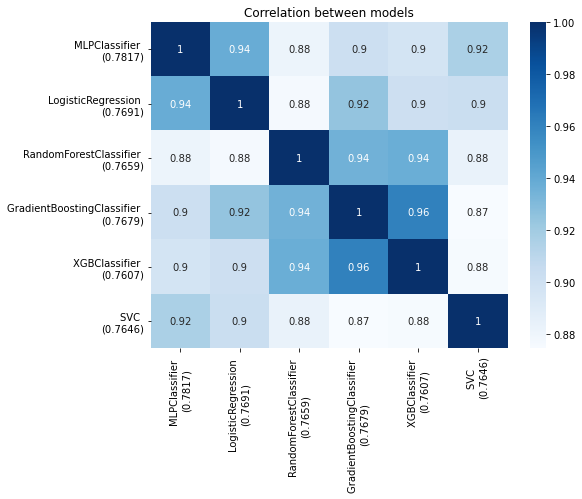

In [15]:
pred_results = []
for name, clf, clf_score in clfs_tuned:
    pred = clf.predict_proba(X_dev)[:,1]
    name = f'{name} \n({clf_score:.4f})'
    pred_results.append(pd.Series(pred, name=name))
ensemble_results = pd.concat(pred_results, axis=1)

# 모형의 예측값 간의 상관관계를 보기 위해 hitmap을 도식한다.
plt.figure(figsize = (8,6))
g = sns.heatmap(ensemble_results.corr(), annot=True, cmap='Blues')
g.set_title("Correlation between models")
plt.show()

*Mean agreement vs. Performance*

In [16]:
# Mean agreement
(ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)

MLPClassifier \n(0.7817)                 0.907138
LogisticRegression \n(0.7691)            0.908779
RandomForestClassifier \n(0.7659)        0.902766
GradientBoostingClassifier \n(0.7679)    0.919484
XGBClassifier \n(0.7607)                 0.914486
SVC \n(0.7646)                           0.890563
dtype: float64

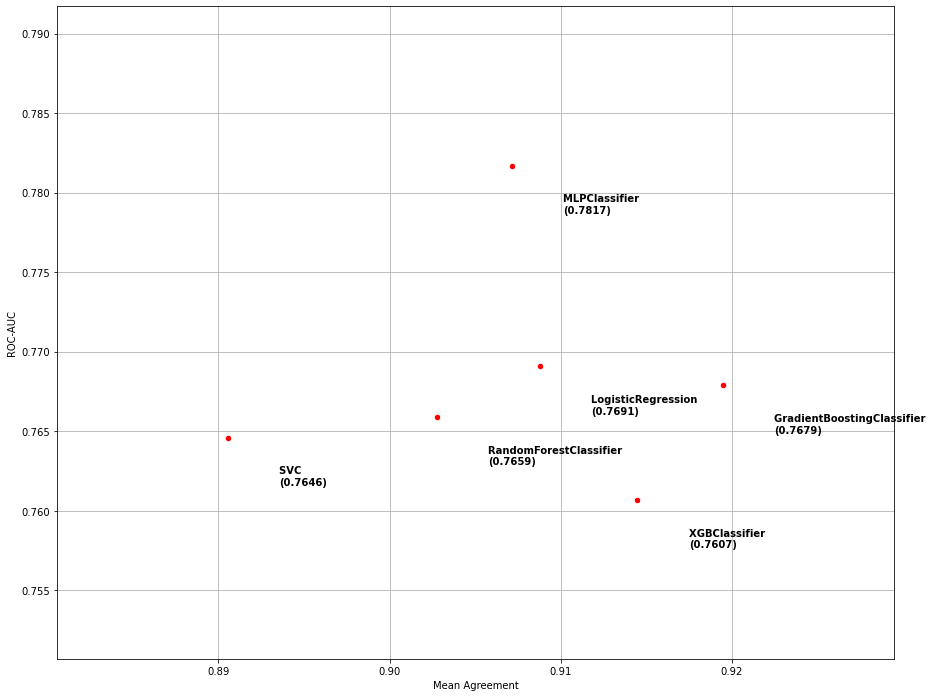

In [17]:
corr = (ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)
names = corr.index
aucs = np.array(corr.index.str[-7:-1]).astype(float)
df = pd.DataFrame({'model': names, 'auc': aucs, 'cor': corr})        

plt.figure(figsize=(15,12))
g = sns.scatterplot(x="cor", y="auc", data=df, s=40, color='red')
for line in range(0, df.shape[0]):
     g.text(df.cor[line]+0.003, df.auc[line]-0.003, 
            df.model[line], horizontalalignment='left', 
            size='medium', color='black', weight='semibold')
        
plt.xlim((df.cor.min()-0.01,df.cor.max()+0.01))
plt.ylim((df.auc.min()-0.01,df.auc.max()+0.01))
plt.xlabel('Mean Agreement')
plt.ylabel('ROC-AUC')
plt.grid()
plt.show()

*Averaging Ensemble*

In [18]:
# Averaging 앙상블에 사용하지 않을 모델은 주석 처리하시오.
selected = [ 
    'MLPClassifier',
    'LogisticRegression', 
    'RandomForestClassifier', 
    'GradientBoostingClassifier',
    'XGBClassifier',
    'SVC'
]
models_for_ensemble = [clf for clf in clfs_tuned if clf[0] in selected]

In [19]:
max_score = 0
for p in tqdm([0, 1, 2.56]):  # p==1:산술평균, p=0:기하평균, 그 외:멱평균(주의:멱평균은 과적합 가능성이 높음)    
    for i in range(3, len(models_for_ensemble)+1): # 3개 이상의 모델이 앙상블된 것들 중 가장 성능이 좋은 것을 선택
        for models in combinations(models_for_ensemble, i):
            if p == 0:
                pred_mean = gmean([clf.predict_proba(X_dev)[:,1] for name, clf, _ in models], axis=0)
            else:
                preds = [clf.predict_proba(X_dev)[:,1] for name, clf, _ in models]
                pred_mean = (np.sum(np.array(preds)**p, axis=0) / len(models))**(1/p)
            score = roc_auc_score(y_dev, pred_mean)
            if max_score < score:
                best_avg_ensemble = (p, models, score)
                max_score = score

p, models, score = best_avg_ensemble
print('p={}\n{}\n{}'.format(p, '●'.join([clf_name for clf_name, _, _ in models]), score))

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:31<00:00, 10.54s/it]

p=1
MLPClassifier●LogisticRegression●RandomForestClassifier
0.7819228911005894


In [20]:
# sklearn의 다른 classifier와 호환성을 갖기위해 Custom Classifier인 "AveragingClassifier" 생성

class AveragingClassifier(ClassifierMixin):
    def __init__(self, estimators, p):
        self.estimators = estimators
        self.p = p
    
    def fit(self, X, y):
        return None

    def predict(self, X):
        if self.p == 0:
            pred = gmean([clf.predict(X) for name, clf in estimators], axis=0)
        else:
            preds = [clf.predict(X) for name, clf in estimators]
            pred = (np.sum(np.array(preds)**self.p, axis=0) / len(estimators))**(1/self.p)
        return pred
         
    def predict_proba(self, X):
        if self.p == 0:
            prob = gmean([clf.predict_proba(X) for name, clf in estimators], axis=0)
        else:
            probs = [clf.predict_proba(X) for name, clf in estimators]
            prob = (np.sum(np.array(probs)**self.p, axis=0) / len(estimators))**(1/self.p)
        return prob
    
estimators = [(name, clf) for name, clf, _ in models]
avg_clf = AveragingClassifier(estimators, p)
avg_clf.fit(X_train, y_train)    

### 6. Deployment

In [21]:
# Averaging ensemble을 적용한 submission
pd.DataFrame({'cust_id': test_id, 'gender': avg_clf.predict_proba(X_test)[:,1]}).to_csv(os.path.abspath("../dat/submissions")+'/조기흠-submission-features.csv', index=False)

<font color="#CC3D3D"><p>
# End